# ML Classification Projects

### Imports

In [1]:
# Pre-processing
import urllib.request as req
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.gridspec as gd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Classification pre-processing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

# K Nearest Neighborhood
from sklearn.neighbors import KNeighborsClassifier as knn

# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# Support Vector Machine
from sklearn import svm

# Logistic Regression
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

### Load Dataset
This dataset is about past loans. The Loan_train.csv data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

In [2]:
url = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv"
file = "load_train.csv"
req.urlretrieve(url, file)

('load_train.csv', <http.client.HTTPMessage at 0x1b1d5ce5dc0>)

### Load dataset from CSV file

In [3]:
df = pd.read_csv('load_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


## Data Visualisation

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

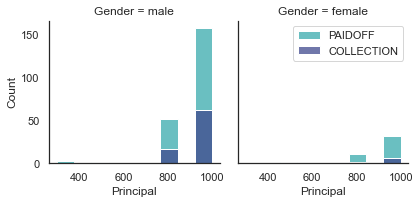

In [7]:
# Principal of loan by gender

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.set_theme(style = 'white')
g = sns.FacetGrid(df, col = "Gender", hue = "loan_status", palette = "mako_r", col_wrap = 2)
g.map(sns.histplot, "Principal", bins = bins, multiple = "stack")

g.axes[-1].legend()
plt.show()

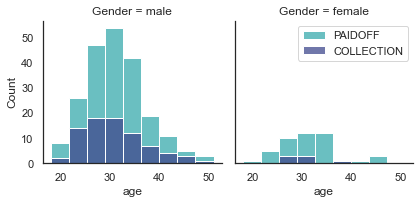

In [8]:
# Age of people taking out loan by gender

bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="mako_r", col_wrap=2)
g.map(sns.histplot, "age", bins = bins)

g.axes[-1].legend()
plt.show()

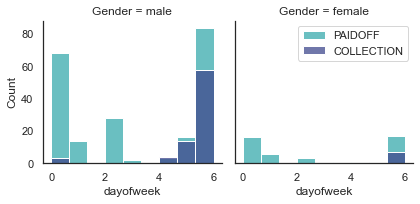

In [9]:
# Days of week people took out loan

df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="mako_r", col_wrap=2)
g.map(sns.histplot, 'dayofweek', bins=bins)

g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

## Data Pre-processing: Feature selection/extraction

In [10]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


### Convert Categorical features to numerical values
Gender Encoding

In [11]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize = True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

In [12]:
df['Gender'].replace(to_replace = ['male','female'], value = [0,1], inplace = True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


Onehot Encoding Education

In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize = True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

In [14]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis = 1)
Feature.drop(['Master or Above'], axis = 1, inplace = True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection

In [15]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [16]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

### Normalize Dataset
Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [17]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification

Split Dataset into Training-Testing Dataset

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## K Nearest Neighbourhood

In [19]:
# Fit KNN Models

mean_accuracy = []

for n in range(1, 10):
    knn_model = knn(n_neighbors = n)
    knn_model.fit(X_train, y_train)
    knn_yhat = knn_model.predict(X_test)
    mean_accuracy.append(accuracy_score(y_test, knn_yhat))

k = 1 has a score = 0.7
k = 2 has a score = 0.6428571428571429
k = 3 has a score = 0.7285714285714285
k = 4 has a score = 0.7142857142857143
k = 5 has a score = 0.7285714285714285
k = 6 has a score = 0.7142857142857143
k = 7 has a score = 0.7857142857142857
k = 8 has a score = 0.7571428571428571
k = 9 has a score = 0.7428571428571429


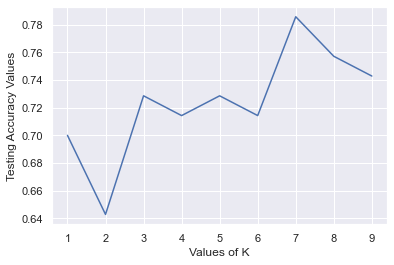

In [20]:
# KNN Model Evaluation

for i in range(0, len(mean_accuracy)):
    print("k = {} has a score = {}".format(i+1, mean_accuracy[i]))

sns.set_style("darkgrid")
plt.plot(range(1, 10), mean_accuracy)
plt.xlabel('Values of K', fontsize = 12)
plt.ylabel('Testing Accuracy Values', fontsize = 12)
plt.show()

For K = 2 and K = 8 has highest value of Testing Accuracy Value

In [21]:
# Training KNN Model with 8 Neighborhoods

neigh_ = knn(n_neighbors = 8)
neigh_.fit(X_train, y_train)
yhat_knn = neigh_.predict(X_test)

neigh_

KNeighborsClassifier(n_neighbors=8)

## Decision Tree

In [22]:
# Fit Decision Tree Models

mean_accuracy = []

for d in range(1, 10):
    dt = DecisionTreeClassifier(criterion = 'gini', max_depth = d)
    dt.fit(X_train, y_train)
    dt_yhat = dt.predict(X_test)
    mean_accuracy.append(f1_score(y_test, dt_yhat, average = 'weighted', pos_label = 'PAIDOFF'))

d = 0 has a f1 score = 0.6524970963995355
d = 1 has a f1 score = 0.6524970963995355
d = 2 has a f1 score = 0.6524970963995355
d = 3 has a f1 score = 0.6763313241782142
d = 4 has a f1 score = 0.6577391304347826
d = 5 has a f1 score = 0.6858023332599603
d = 6 has a f1 score = 0.6857142857142857
d = 7 has a f1 score = 0.7028571428571428
d = 8 has a f1 score = 0.6857142857142857


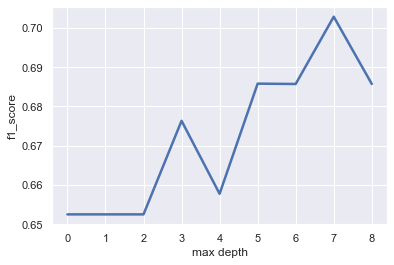

In [23]:
# Decision Tree Model Evaluation

for i in range(0, len(mean_accuracy)):
    print('d = {} has a f1 score = {}'.format(i+0, mean_accuracy[i]))

sns.set_style("darkgrid")
sns.lineplot(x = range(0, 9), y = mean_accuracy, linewidth = 2.5)
plt.ylabel('f1_score', fontsize = 12)
plt.xlabel('max depth', fontsize = 12)
plt.show()

Around max depth = 5 f1_score is highest

In [24]:
# Training Decision Tree with max depth = 5

tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 4)
tree.fit(X_train, y_train)
tree

DecisionTreeClassifier(max_depth=4)

## Support Vector Machine

In [25]:
# Fit different SVM Model

kernel_func = ['sigmoid', 'poly', 'rbf', 'linear']
mean_accuracy = []

for k in kernel_func:
    svc_model = svm.SVC(C = 0.01, gamma = 'auto', kernel = k)
    svc_model.fit(X_train, y_train)
    svc_yhat = svc_model.predict(X_test)
    mean_accuracy.append(f1_score(y_test, svc_yhat, pos_label = 'PAIDOFF'))

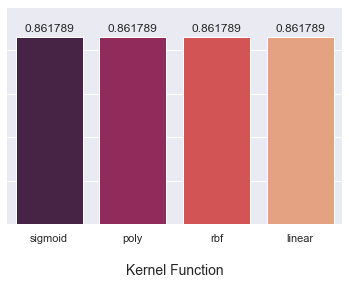

In [26]:
# Model Visualisation

plots = sns.barplot(x = kernel_func, y = mean_accuracy, palette = 'rocket')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.6f'), (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                  ha = 'center', va = 'center', size = 12, xytext = (0, 8), textcoords = 'offset points')
sns.despine(left = True, bottom = True)
sns.set_style('white')
plt.tick_params(labelleft = False, left = False)
plt.ylim([0, 1])
plt.xlabel("\nKernel Function", fontsize = 14)
plt.show()

Accuracy of different kernel function is same. So we will use 'linear' function to train model.

In [27]:
# Training SVM with linear kernel function

clf = svm.SVC(C = 0.01, gamma = 'auto', kernel = 'linear')
clf.fit(X_train, y_train)
clf

SVC(C=0.01, gamma='auto', kernel='linear')

## Logistic Regression

In [28]:
# Model Training

solvers = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
regularization_val = [0.1, 0.01, 0.001]
mean_logloss = []

for c in regularization_val:
    for solver in solvers:
        lr_model = LogisticRegression(C = c, solver = solver)
        lr_model.fit(X_train, y_train)
        lr_yhat = lr_model.predict_proba(X_test)
        score = log_loss(y_test, lr_yhat)
        print('Accuracy = {}    for C = {} and Solver = {}'.format(score, c, solver))
        mean_logloss.append(score)
    print('\n')

Accuracy = 0.45909710044785085    for C = 0.1 and Solver = liblinear
Accuracy = 0.44720066709682477    for C = 0.1 and Solver = newton-cg
Accuracy = 0.44720122397561085    for C = 0.1 and Solver = lbfgs
Accuracy = 0.4471956665088851    for C = 0.1 and Solver = sag
Accuracy = 0.4471990481917436    for C = 0.1 and Solver = saga


Accuracy = 0.55845787057088    for C = 0.01 and Solver = liblinear
Accuracy = 0.49605255036359563    for C = 0.01 and Solver = newton-cg
Accuracy = 0.4960526443270092    for C = 0.01 and Solver = lbfgs
Accuracy = 0.4960468223295355    for C = 0.01 and Solver = sag
Accuracy = 0.49605474676107214    for C = 0.01 and Solver = saga


Accuracy = 0.6676081588694727    for C = 0.001 and Solver = liblinear
Accuracy = 0.5442860144094683    for C = 0.001 and Solver = newton-cg
Accuracy = 0.5442860122054438    for C = 0.001 and Solver = lbfgs
Accuracy = 0.5442850510294623    for C = 0.001 and Solver = sag
Accuracy = 0.5442860665092751    for C = 0.001 and Solver = saga




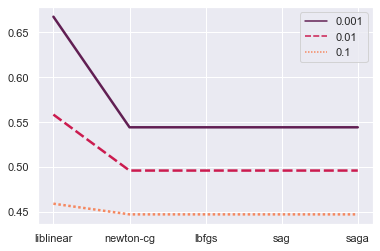

In [29]:
# Model Evaluation

dictionary = {0.1: mean_logloss[0:5],
             0.01: mean_logloss[5:10],
             0.001: mean_logloss[10:15]}

sns.set_style("darkgrid")
sns.lineplot(data = pd.DataFrame.from_dict(dictionary), palette = "rocket", linewidth = 2.5)
plt.xticks([0.0, 1.0, 2.0, 3.0, 4.0], labels = solvers)
plt.show()

Using 'liblinear' function for Logistic Regression yeilds highest accuracy

In [30]:
# Training Logistic Regression Model with 'liblinear' function

LR = LogisticRegression(C = 0.001, solver = 'liblinear')
LR.fit(X_train, y_train)
LR

LogisticRegression(C=0.001, solver='liblinear')

# Model Evaluation using Test Set

In [31]:
# Download Test Dataset

url = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv"
file = "load_test.csv"
req.urlretrieve(url, file)

('load_test.csv', <http.client.HTTPMessage at 0x1b1db86cfd0>)

In [32]:
# Load Model for Evaluation

test_df = pd.read_csv('load_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [33]:
# Data Pre-processing

test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

X_test_ = test_df[['Principal','terms','age','Gender', 'weekend']]
X_test_ = pd.concat([X_test_,pd.get_dummies(test_df['education'])], axis=1)
X_test_.drop(['Master or Above'], axis = 1,inplace=True)

X_test_ = preprocessing.StandardScaler().fit(X_test_).transform(X_test_)

y_test_ = test_df['loan_status'].values

print(X_test_[0:5])
print(y_test_[0:5])

[[ 0.49362588  0.92844966  3.05981865  1.97714211 -1.30384048  2.39791576
  -0.79772404 -0.86135677]
 [-3.56269116 -1.70427745  0.53336288 -0.50578054  0.76696499 -0.41702883
  -0.79772404 -0.86135677]
 [ 0.49362588  0.92844966  1.88080596  1.97714211  0.76696499 -0.41702883
   1.25356634 -0.86135677]
 [ 0.49362588  0.92844966 -0.98251057 -0.50578054  0.76696499 -0.41702883
  -0.79772404  1.16095912]
 [-0.66532184 -0.78854628 -0.47721942 -0.50578054  0.76696499  2.39791576
  -0.79772404 -0.86135677]]
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


### Model Evaluation for Different Classifications

In [34]:
# For KNN Algorithm

ytest_knn = neigh_.predict(X_test_)

jaccard_knn = jaccard_score(y_test_, ytest_knn, pos_label = 'PAIDOFF')
f1_knn = f1_score(y_test_, ytest_knn, pos_label = 'PAIDOFF')

print("jaccard score for KNN = ", jaccard_knn)
print("F1 score for KNN = ", f1_knn)

jaccard score for KNN =  0.6938775510204082
F1 score for KNN =  0.8192771084337349


In [35]:
# For Decision Tree Algorithm

ytest_tree = tree.predict(X_test_)

jaccard_tree = jaccard_score(y_test_, ytest_tree, pos_label = 'PAIDOFF')
f1_tree = f1_score(y_test_, ytest_tree, pos_label = 'PAIDOFF')

print("jaccard score for Decision Tree = ", jaccard_tree)
print("F1 score for Decision Tree = ", f1_tree)

jaccard score for Decision Tree =  0.7647058823529411
F1 score for Decision Tree =  0.8666666666666667


In [36]:
# For SVM Algorithm

ytest_svm = clf.predict(X_test_)

jaccard_svm = jaccard_score(y_test_, ytest_svm, pos_label = 'PAIDOFF')
f1_svm = f1_score(y_test_, ytest_svm, pos_label = 'PAIDOFF')

print("jaccard score for SVM = ", jaccard_svm)
print("F1 score for SVM = ", f1_svm)

jaccard score for SVM =  0.7407407407407407
F1 score for SVM =  0.851063829787234


In [37]:
# For Logistic Regression Algorithm

ytest_lr = LR.predict(X_test_)
ytest_lr_ = LR.predict_proba(X_test_)

jaccard_lr = jaccard_score(y_test_, ytest_lr, pos_label = 'PAIDOFF')
f1_lr = f1_score(y_test_, ytest_lr, pos_label = 'PAIDOFF')
logloss = log_loss(y_test_, ytest_lr_)

print("jaccard score for LR = ", jaccard_lr)
print("F1 score for LR = ", f1_lr)
print("Log-Loss for LR = ", logloss)

jaccard score for LR =  0.7843137254901961
F1 score for LR =  0.8791208791208792
Log-Loss for LR =  0.6691574976376283


### Report

In [38]:
Report = {'Algorithm': ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression'],
         'Jaccard': [jaccard_knn, jaccard_tree, jaccard_svm, jaccard_lr],
         'F1-score': [f1_knn, f1_tree, f1_svm, f1_lr],
         'LogLoss': ['NA', 'NA', 'NA', logloss]}

Report_df = pd.DataFrame.from_dict(Report)

Report_df

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.693878,0.819277,NA
1,Decision Tree,0.764706,0.866667,NA
2,SVM,0.740741,0.851064,NA
3,Logistic Regression,0.784314,0.879121,0.669157


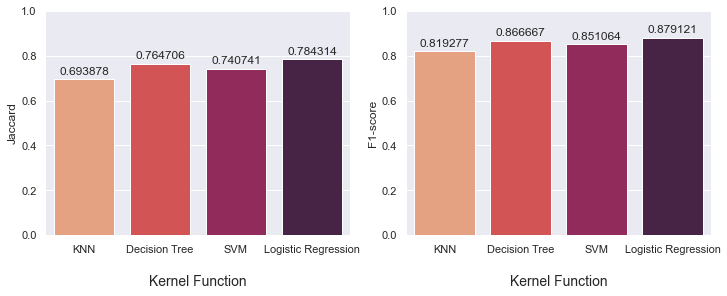

In [39]:
fig = plt.figure(constrained_layout = True, figsize = (10, 4))
grid = gd.GridSpec(ncols = 2, nrows = 1, figure = fig)
sns.set_theme(style = "darkgrid")

ax1 = fig.add_subplot(grid[0, :1])
sns.despine(fig, left = True, bottom = True, ax = ax1)
g = sns.barplot(x = "Algorithm", y = "Jaccard", data = Report_df, label="Total", palette = "rocket_r", ax = ax1)
for bar in g.patches:
    g.annotate(format(bar.get_height(), '.6f'), (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha = 'center',
               va = 'center', size = 12, xytext = (0, 8), textcoords = 'offset points')
sns.despine(left = True, bottom = True, ax = ax1)
plt.ylim([0, 1])
plt.xlabel("\nKernel Function", fontsize = 14)

ax2 = fig.add_subplot(grid[0, 1:])
sns.despine(fig, left = True, bottom = True, ax = ax2)
g2 = sns.barplot(x = "Algorithm", y = "F1-score", data = Report_df, label="Total", palette = "rocket_r", ax = ax2)
for bar in g2.patches:
    g2.annotate(format(bar.get_height(), '.6f'), (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha = 'center',
               va = 'center', size = 12, xytext = (0, 8), textcoords = 'offset points')
sns.despine(left = True, bottom = True, ax = ax2)
plt.ylim([0, 1])
plt.xlabel("\nKernel Function", fontsize = 14)

plt.show()

___